# 1. Data Gathering and Analysis

In [1]:
import praw
import pandas as pd
import json
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [2]:
df_general = pd.read_csv('../data/aot_general.csv')
df_ending = pd.read_csv('../data/aot_ending.csv')
df_general['created_utc'] = pd.to_datetime(df_general['created_utc'])
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])

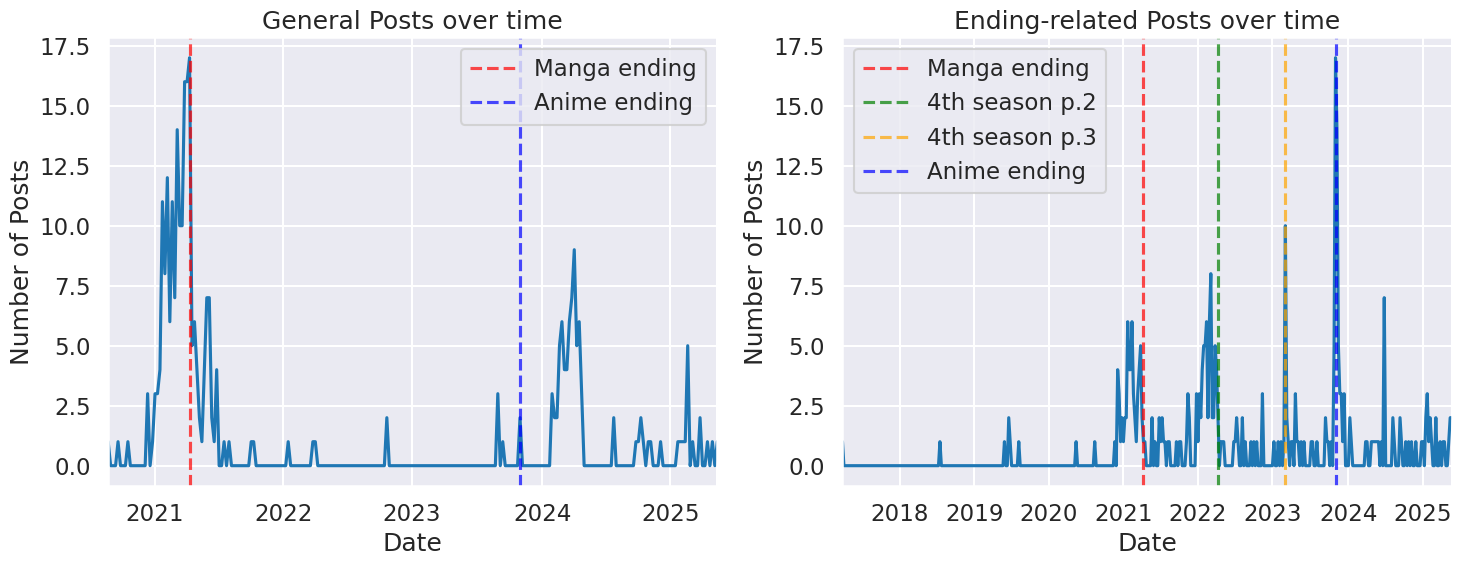

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# W stands for Week
df_general.set_index('created_utc').resample('W').size().plot(ax=axes[0], title="General Posts over time")
axes[0].axvline(pd.to_datetime('2021-04-09'), color='red', linestyle='--', alpha=0.7, label='Manga ending')
axes[0].axvline(pd.to_datetime('2023-11-05'), color='blue', linestyle='--', alpha=0.7, label='Anime ending')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Posts')
axes[0].legend()

df_ending.set_index('created_utc').resample('W').size().plot(ax=axes[1], title="Ending-related Posts over time")
axes[1].axvline(pd.to_datetime('2021-04-09'), color='red', linestyle='--', alpha=0.7, label='Manga ending')
axes[1].axvline(pd.to_datetime('2022-04-04'), color='green', linestyle='--', alpha=0.7, label='4th season p.2')
axes[1].axvline(pd.to_datetime('2023-03-04'), color='orange', linestyle='--', alpha=0.7, label='4th season p.3')
axes[1].axvline(pd.to_datetime('2023-11-05'), color='blue', linestyle='--', alpha=0.7, label='Anime ending')


axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Posts')
axes[1].legend()

plt.tight_layout()
plt.show()

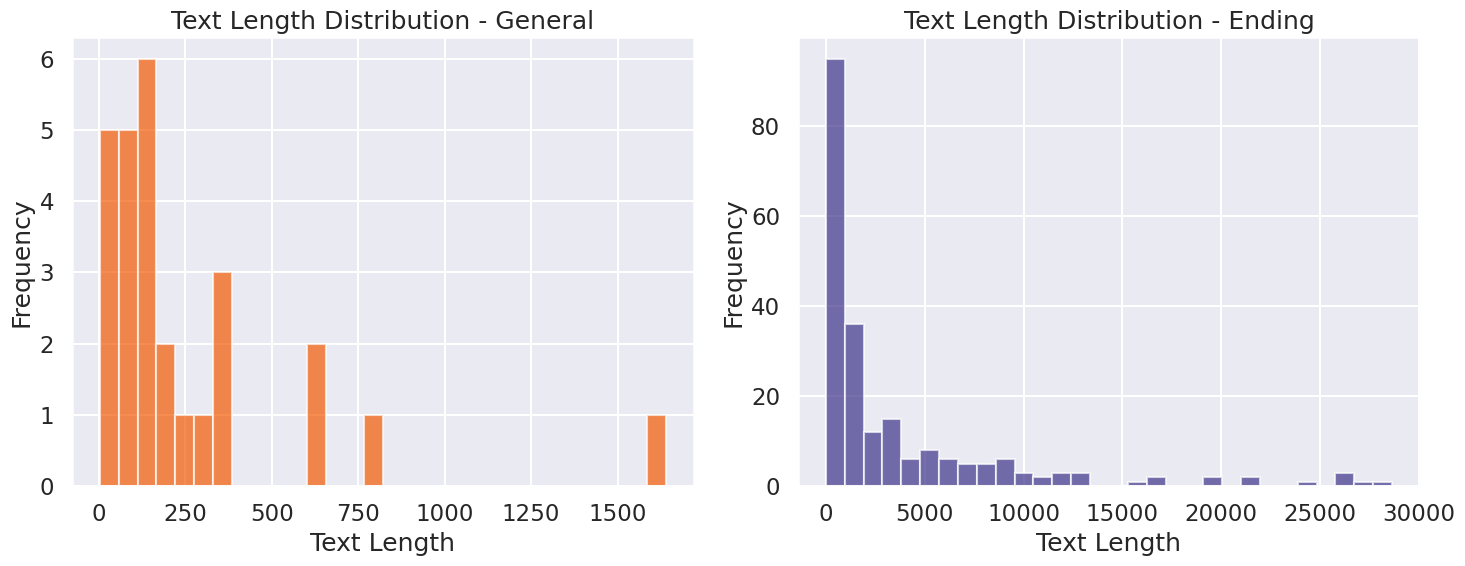

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate text length for general posts
df_general['text_length'] = df_general['selftext'].dropna().str.len()
df_ending['text_length'] = df_ending['selftext'].dropna().str.len()

# Filter out extreme outliers for better visualization (99th percentile)
general_length_99th = df_general['text_length'].quantile(0.99)
ending_length_99th = df_ending['text_length'].quantile(0.99)

df_general[df_general['text_length'] <= general_length_99th]['text_length'].hist(bins=30, ax=axes[0], alpha=0.7, color='#f35b04')
axes[0].set_title("Text Length Distribution - General")
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')

df_ending[df_ending['text_length'] <= ending_length_99th]['text_length'].hist(bins=30, ax=axes[1], alpha=0.7, color='#3d348b')
axes[1].set_title("Text Length Distribution - Ending")
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

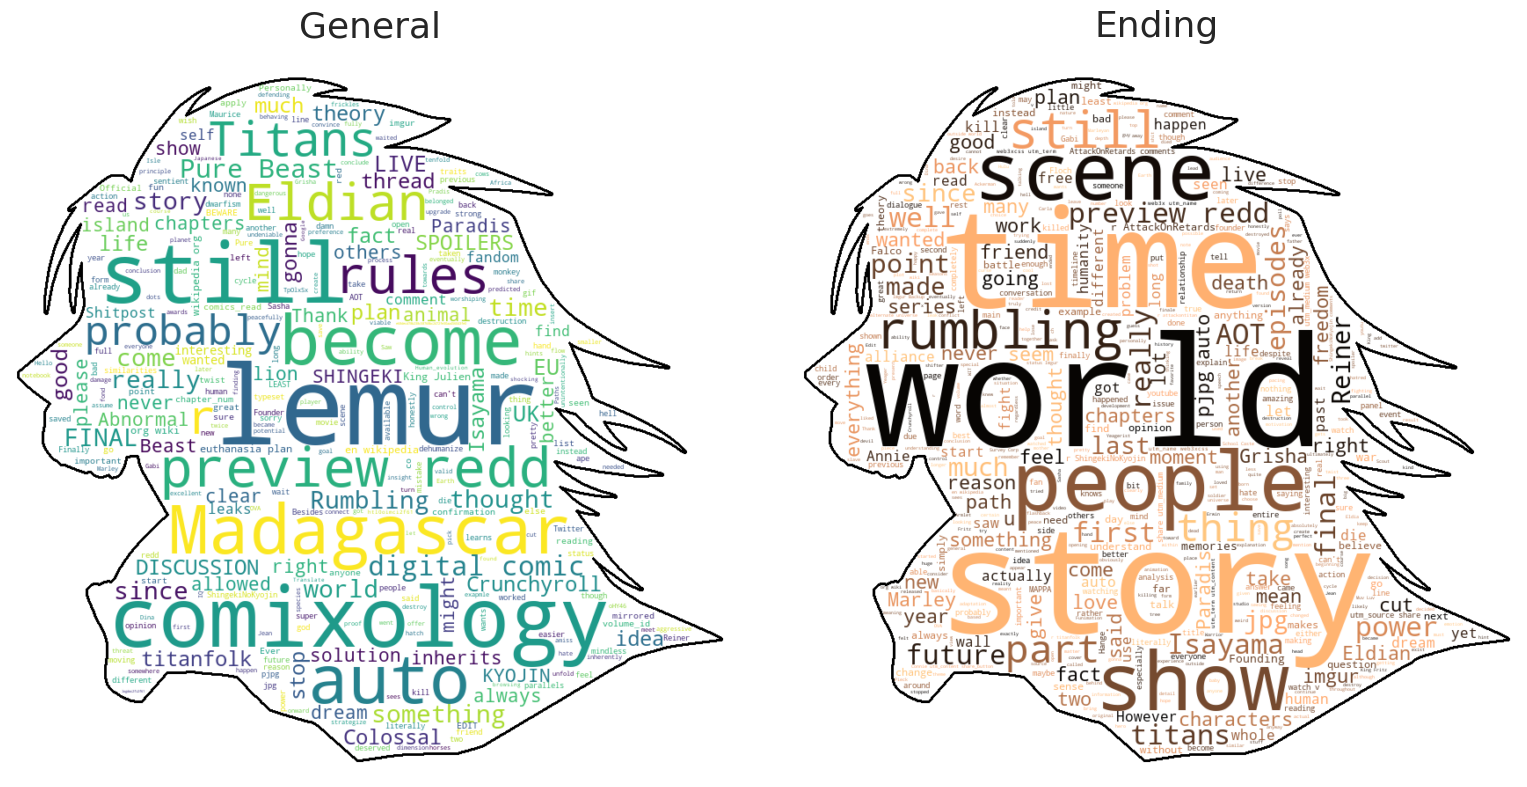

In [5]:
# mask
img = Image.open('../images/mask_erenTitanForm.jpeg')
eren_mask = np.array(img).mean(axis=2).astype(np.uint8)
threshold = 128  # You can adjust this value
eren_mask = np.where(eren_mask > threshold, 255, 0).astype(np.uint8)


nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

# Combine all selftext
all_selftext_general = ' '.join(df_general['selftext'].dropna().astype(str))
all_selftext_ending = ' '.join(df_ending['selftext'].dropna().astype(str))

# UPDATE STOPWORDS
STOPWORDS.update([
    'Eren', 'Armin', 'Mikasa', 'Levi', 'Zeke', 'Ymir', 'Historia', 'Attack', 'Titan',
    'ending', 'chapter', 'anime', 'manga', 'episode', 'character', 'season',
    'www', 'https', 'x200B', 'com', 'reddit', 'webp', 'png',
    # a bunch of common words that are not useful for the word cloud
    'also', 'like', 'would', 'even', 'think', 'get', 'want', 'one', 'see','know', 'say',
    'format', 'width', 'post', 'arc', 'way', 'make', 'could', 'end'
])

# Create word clouds for both datasets
wordcloud_general = WordCloud(width=800, height=400, 
                             stopwords=STOPWORDS, max_words=500,
                             background_color='white', colormap='viridis',
                             mask=eren_mask, contour_width=2, contour_color='black' # MASK
                    ).generate(all_selftext_general)

wordcloud_ending = WordCloud(width=800, height=400, 
                             stopwords=STOPWORDS, max_words=500,
                             background_color='white', colormap='copper',
                             mask=eren_mask, contour_width=2, contour_color='black' # MASK
                    ).generate(all_selftext_ending)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_general, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('General', fontsize=26)
axes[1].imshow(wordcloud_ending, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Ending', fontsize=26)
plt.tight_layout()
plt.show()

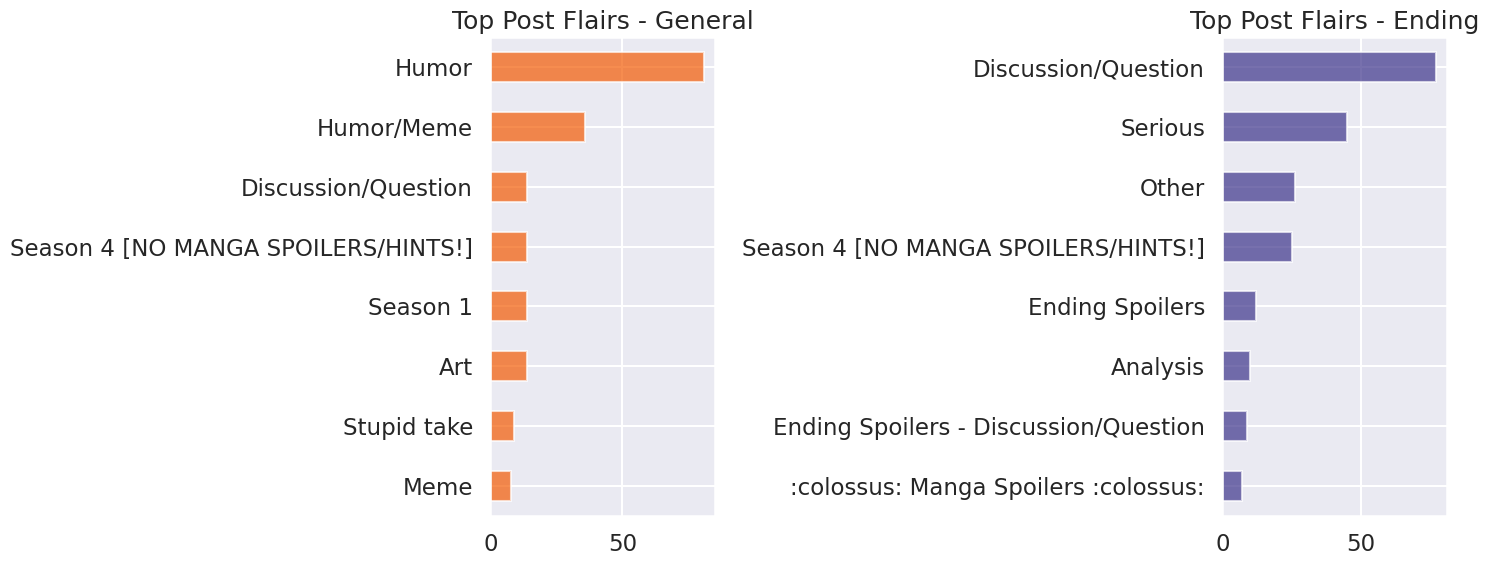

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# have seen that in the data appears "Discussion" and "Discussion ", so we strip the whitespace
df_general['link_flair_text'] = df_general['link_flair_text'].str.strip()
df_ending['link_flair_text'] = df_ending['link_flair_text'].str.strip()

df_general['link_flair_text'].value_counts().head(8).sort_values().plot(kind='barh', ax=axes[0], alpha=0.7, color='#f35b04')
axes[0].set_title("Top Post Flairs - General")
axes[0].set_ylabel('')

df_ending['link_flair_text'].value_counts().head(8).sort_values().plot(kind='barh', ax=axes[1], alpha=0.7, color='#3d348b')
axes[1].set_title("Top Post Flairs - Ending")
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


# 2. Topological analysis

In [7]:
import pickle
import networkx as nx
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))

In [ ]:
pos = nx.spring_layout(G, iterations=50, seed=1721)

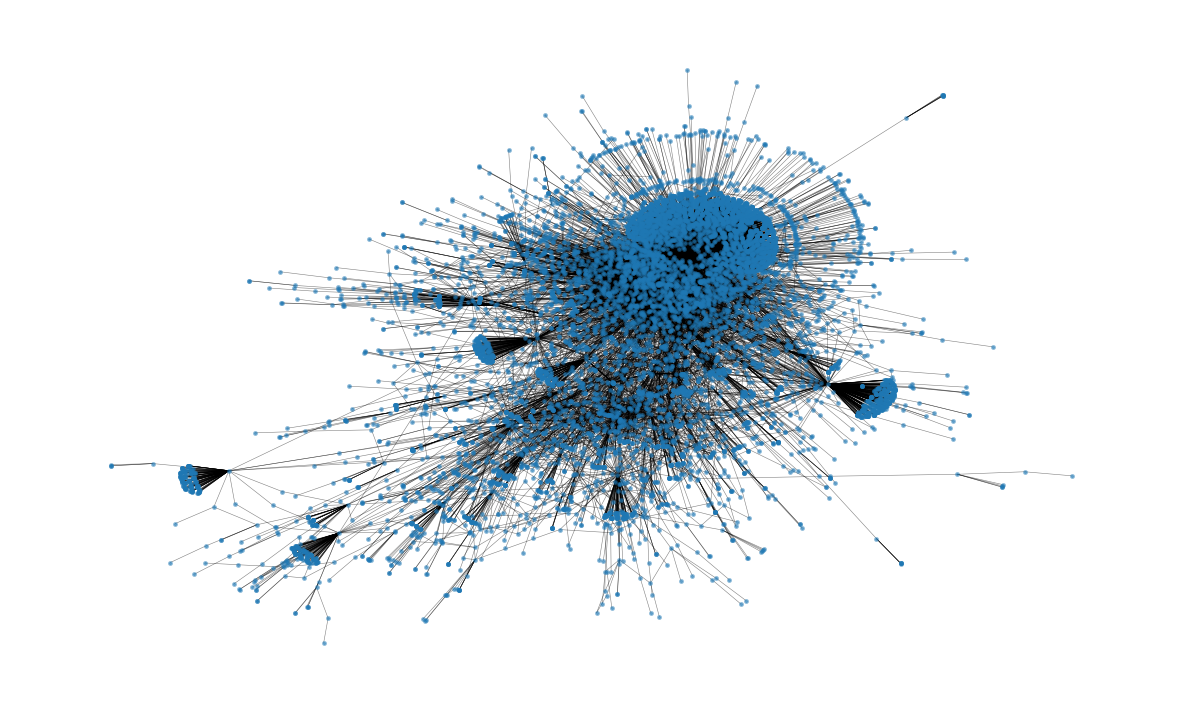

In [31]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=4, width=0.4, alpha=0.5, with_labels=False)

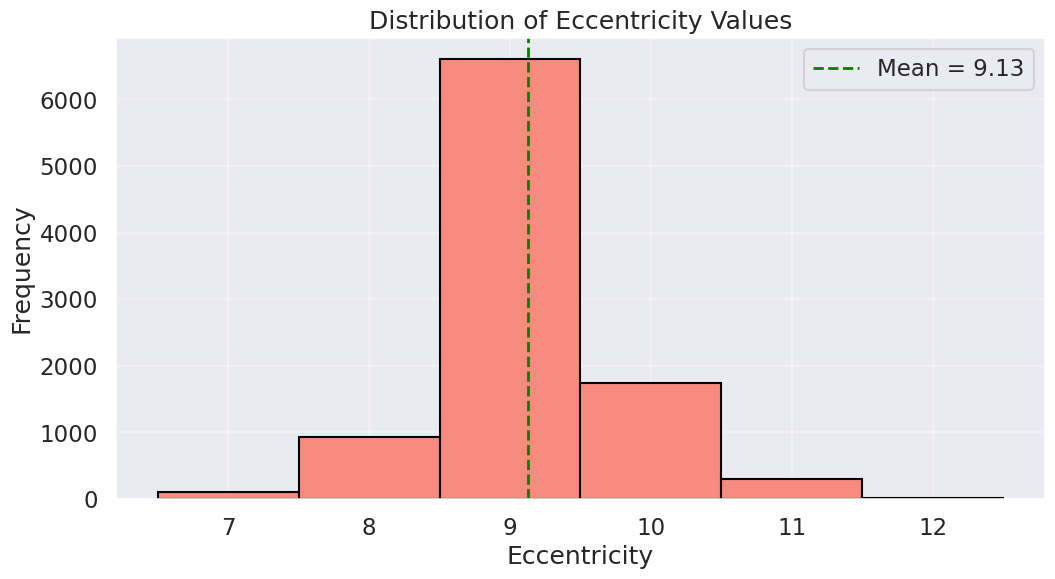

In [8]:
# eccentricity of the nodes
ecc = nx.eccentricity(G)

plt.figure(figsize=(12, 6))
# hitogram of the eccentricity values of our nodes
# center bins on integers
ecc_values = list(ecc.values())
min_ecc = min(ecc_values)
max_ecc = max(ecc_values)
bins = np.arange(min_ecc - 0.5, max_ecc + 1.5, 1)

sns.histplot(ecc_values, bins=bins, alpha=0.9, color='salmon', edgecolor='black')
plt.axvline(np.mean(ecc_values), color='green', linestyle='--', linewidth=2, label=f'Mean = {np.mean(ecc_values):.2f}')
plt.title('Distribution of Eccentricity Values')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.xticks(range(min_ecc, max_ecc + 1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

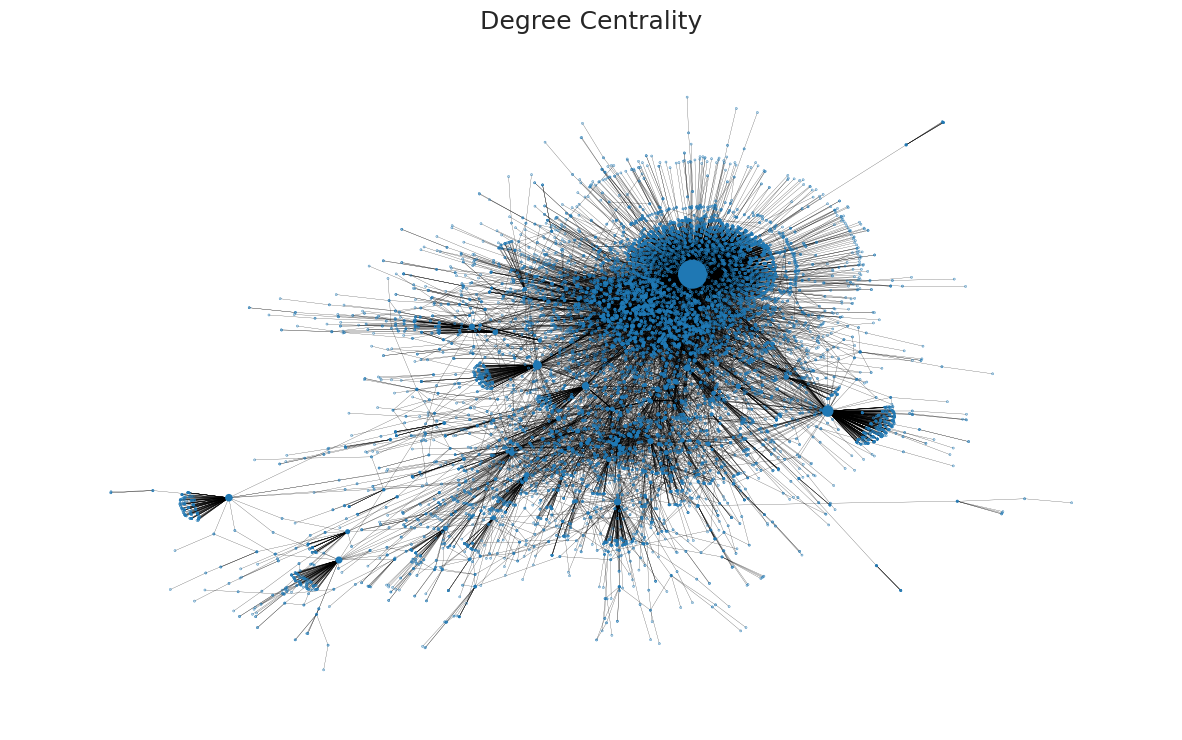

In [10]:
dg_cen = nx.degree_centrality(G)
dg_cen_df= pd.DataFrame(dg_cen.items(), columns=['node','dg_c'])
dg_cen_df = dg_cen_df.sort_values(by='dg_c', ascending=False)

node_size = [np.log(v + 1) * 1000 for v in dg_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels= False, width= 0.15)
ax.set_title("Degree Centrality")
plt.show()

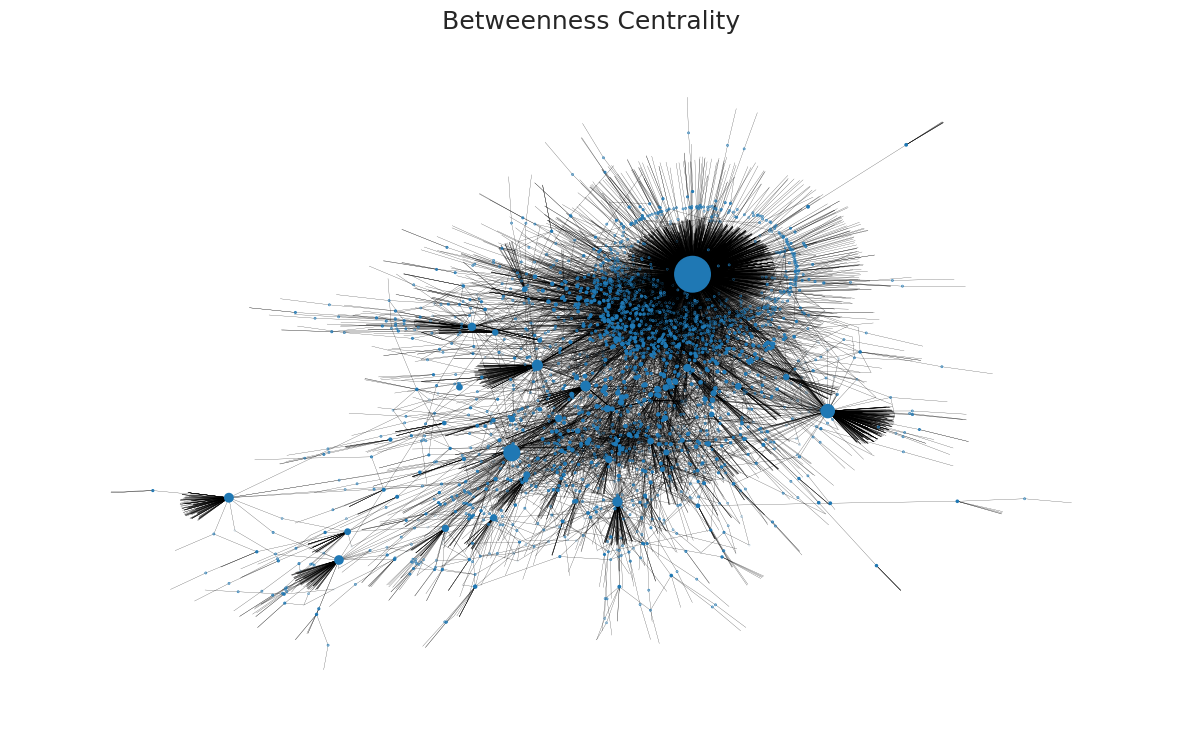

In [11]:
bt_cen = nx.betweenness_centrality(G)
bt_cen_df= pd.DataFrame(bt_cen.items(), columns=['node','bt_c'])
bt_cen_df = bt_cen_df.sort_values(by='bt_c', ascending=False)
node_size = [np.log(v + 1) * 1000 for v in bt_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels= False, width= 0.15)
ax.set_title("Betweenness Centrality")
plt.show()

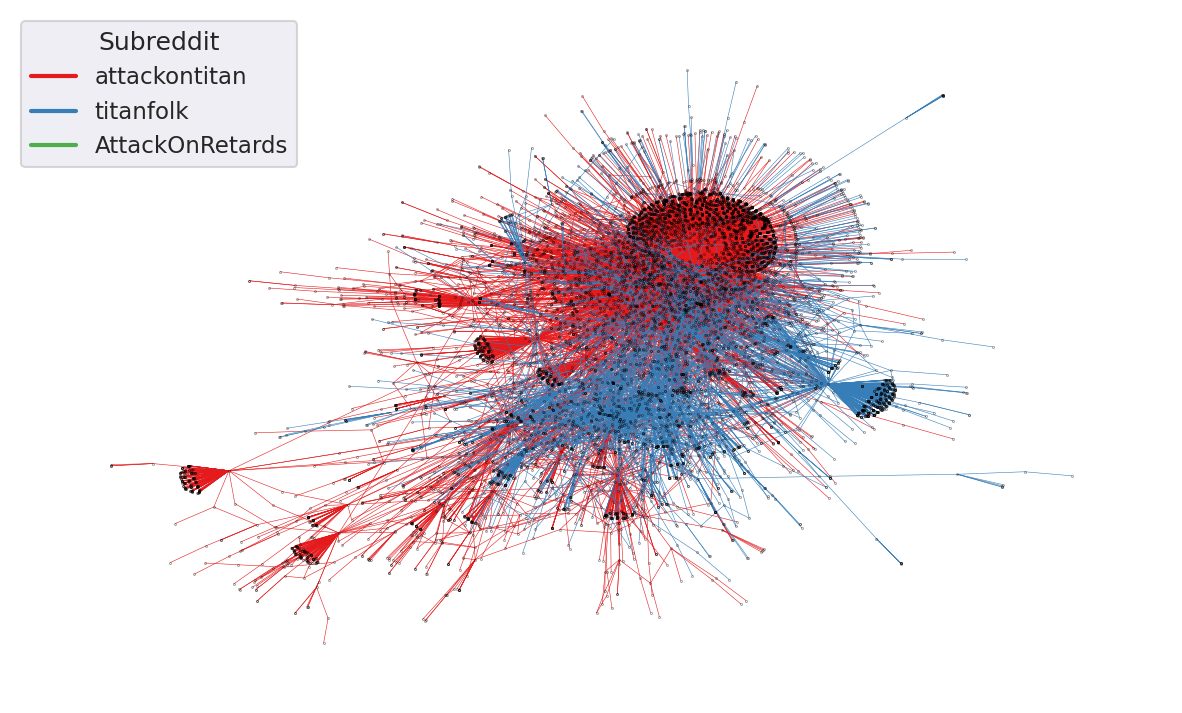

In [39]:
# subreddits to colors mapping
comments_df = pd.read_csv('../data/comments_graph_ending_clean.csv')
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'])
subreddits = comments_df['subreddit'].unique()
palette = sns.color_palette("Set1", n_colors=len(subreddits))
subreddit_to_color = {sub: palette[i] for i, sub in enumerate(subreddits)}

# assign colors to edges based on subreddit
edge_colors = [subreddit_to_color[sub] for sub in comments_df['subreddit']]

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(
    G, pos=pos, ax=ax, 
    node_color='black',
    edge_color=edge_colors, 
    node_size=0.05, 
    with_labels=False, 
    width=0.4
)
# Add legend
for sub, color in subreddit_to_color.items():
    ax.plot([], [], color=color, label=sub, linewidth=3)
ax.legend(title="Subreddit")
plt.show()

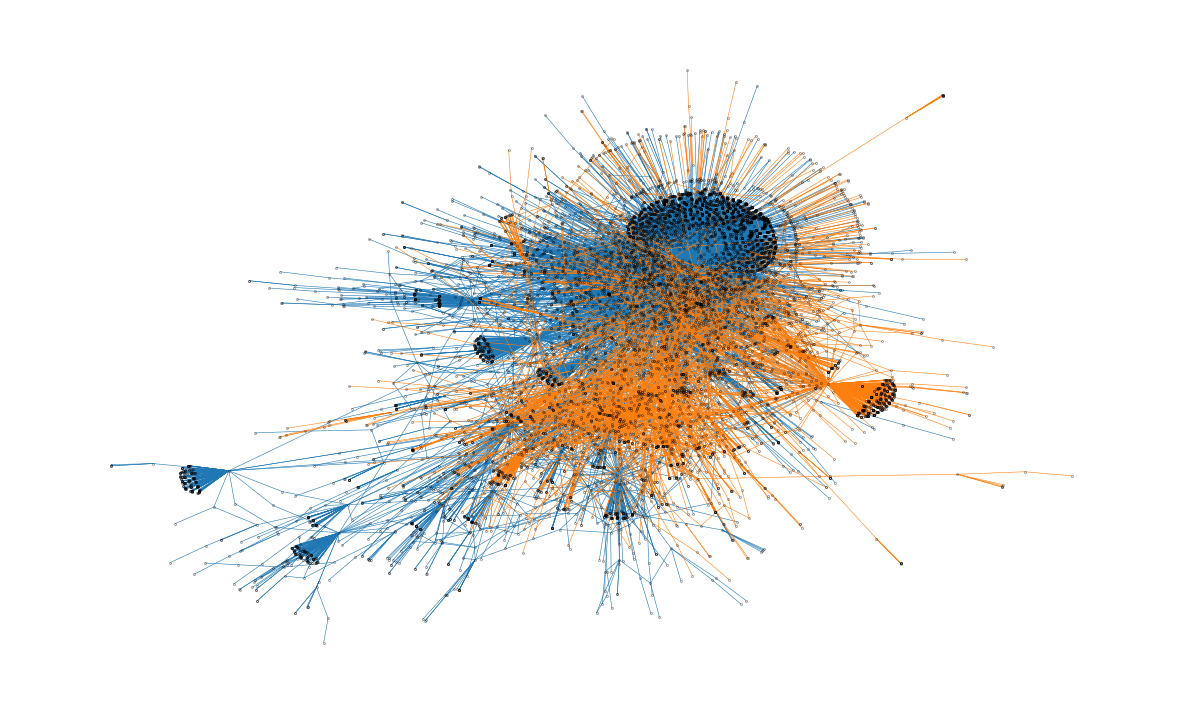

In [40]:
# subreddits to colors mapping
comments_df = pd.read_csv('../data/comments_graph_ending_clean.csv')
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'])
subreddits = comments_df['subreddit'].unique()
palette = sns.color_palette("tab10", n_colors=len(subreddits))
subreddit_to_color = {sub: palette[i] for i, sub in enumerate(subreddits)}

# assign colors to edges based on subreddit
edge_colors = [subreddit_to_color[sub] for sub in comments_df['subreddit']]

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(
    G, pos=pos, ax=ax, 
    node_color='black',
    edge_color=edge_colors, 
    node_size=0.05, 
    with_labels=False, 
    width=0.4
)
plt.show()

In [13]:
# Create a graph from the cleaned comments dataframe
G_attackontitan = nx.Graph()
G_titanfolk = nx.Graph()
G_attackonretards = nx.Graph()
for index, r in comments_df.iterrows():
    if r['subreddit'] == 'attackontitan':
        G_attackontitan.add_edge(r['parent'], r['child'])
    elif r['subreddit'] == 'titanfolk':
        G_titanfolk.add_edge(r['parent'], r['child'])
    elif r['subreddit'] == 'AttackOnRetards':
        G_attackonretards.add_edge(r['parent'], r['child'])

def remove_self_loops_and_largest_cc(G):
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    return G

# Remove self-loops and keep only the largest connected component for each subreddit graph
G_attackontitan = remove_self_loops_and_largest_cc(G_attackontitan)
G_titanfolk = remove_self_loops_and_largest_cc(G_titanfolk)
G_attackonretards = remove_self_loops_and_largest_cc(G_attackonretards)

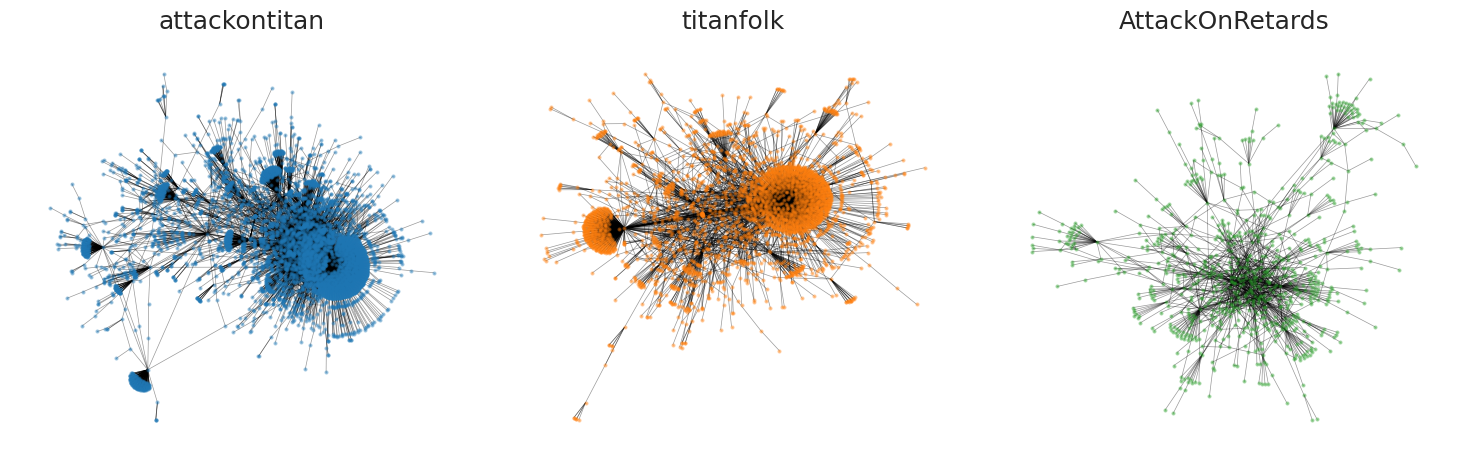

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
titles = ['attackontitan', 'titanfolk', 'AttackOnRetards']
graphs = [G_attackontitan, G_titanfolk, G_attackonretards]
poss = [nx.spring_layout(graph, iterations=50, seed=1721) for graph in graphs]
cmap = plt.cm.tab10

for i in range(3):
    ax = axes[i]
    nx.draw_networkx(graphs[i], pos=poss[i], ax=ax, node_size=2, alpha=0.4, width=0.5, node_color=[cmap(i)], with_labels=False)
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

# 3. Community detection

In [32]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx
from infomap import Infomap
import os

# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])
df_comments = pd.read_csv('../data/comments_graph_ending_final.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))
df_communities = pd.read_csv('../data/communities.csv')

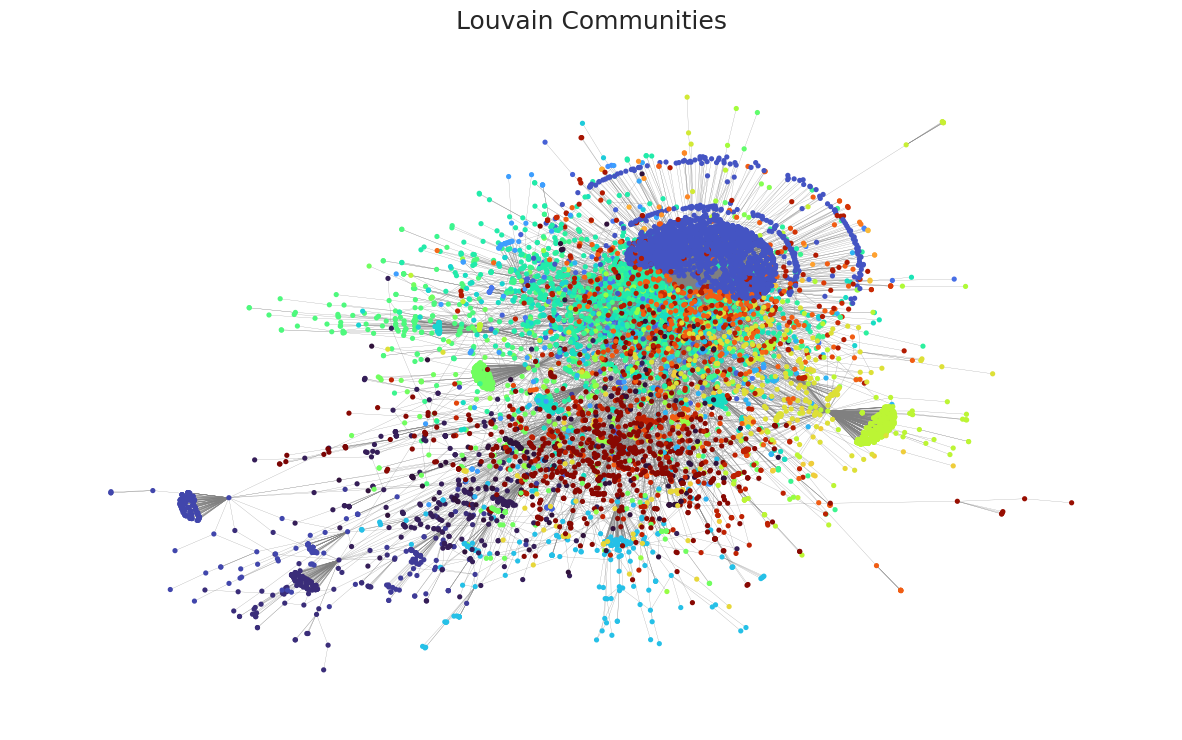

In [33]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
ax.set_title("Louvain Communities")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_communities['louvain_community'], cmap=plt.cm.turbo, edge_color='gray', node_size=5, with_labels=False, width=0.15)

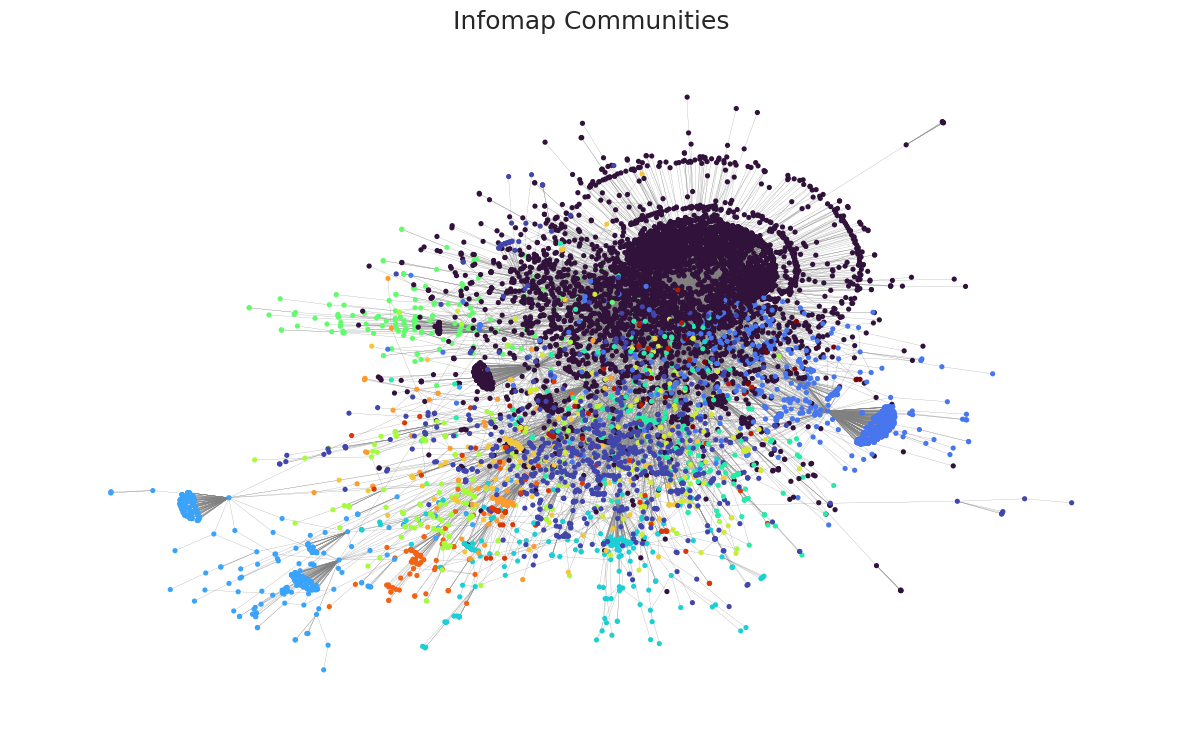

In [34]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
ax.set_title("Infomap Communities")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_communities['infomap_community'], cmap=plt.cm.turbo, edge_color='gray', node_size=5, with_labels=False, width=0.15)

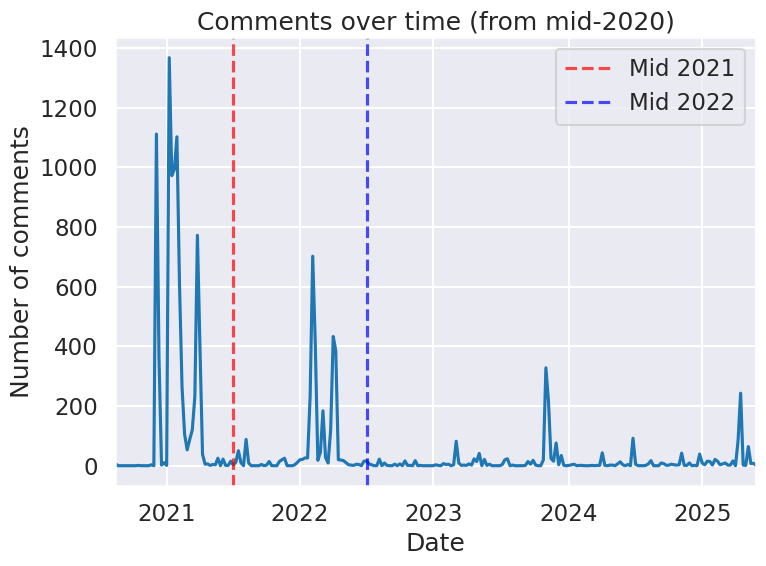

In [35]:
# Filter comments after mid-2020
mid_2020 = pd.Timestamp('2020-06-30')
df_comments_filtered = df_comments[df_comments['created_utc'] > mid_2020]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Plot filtered comments over time
df_comments_filtered.set_index('created_utc').resample('W').size().plot(ax=ax, title="Comments over time (from mid-2020)")

# Add vertical lines for key dates
ax.axvline(pd.to_datetime('2021-06-30'), color='red', linestyle='--', alpha=0.7, label='Mid 2021')
ax.axvline(pd.to_datetime('2022-06-30'), color='blue', linestyle='--', alpha=0.7, label='Mid 2022')

ax.set_xlabel('Date')
ax.set_ylabel('Number of comments')
ax.legend()

plt.tight_layout()
plt.show()

In [36]:
# Define the date ranges
mid_2020 = pd.Timestamp('2020-06-30')
mid_2021 = pd.Timestamp('2021-06-30')
mid_2022 = pd.Timestamp('2022-06-30')

# Filter the DataFrame into three sub-DataFrames
df_comments_2020_2021 = df_comments[(df_comments['created_utc'] > mid_2020) & (df_comments['created_utc'] <= mid_2021)]
df_comments_2021_2022 = df_comments[(df_comments['created_utc'] > mid_2021) & (df_comments['created_utc'] <= mid_2022)]
df_comments_later = df_comments[df_comments['created_utc'] > mid_2022]


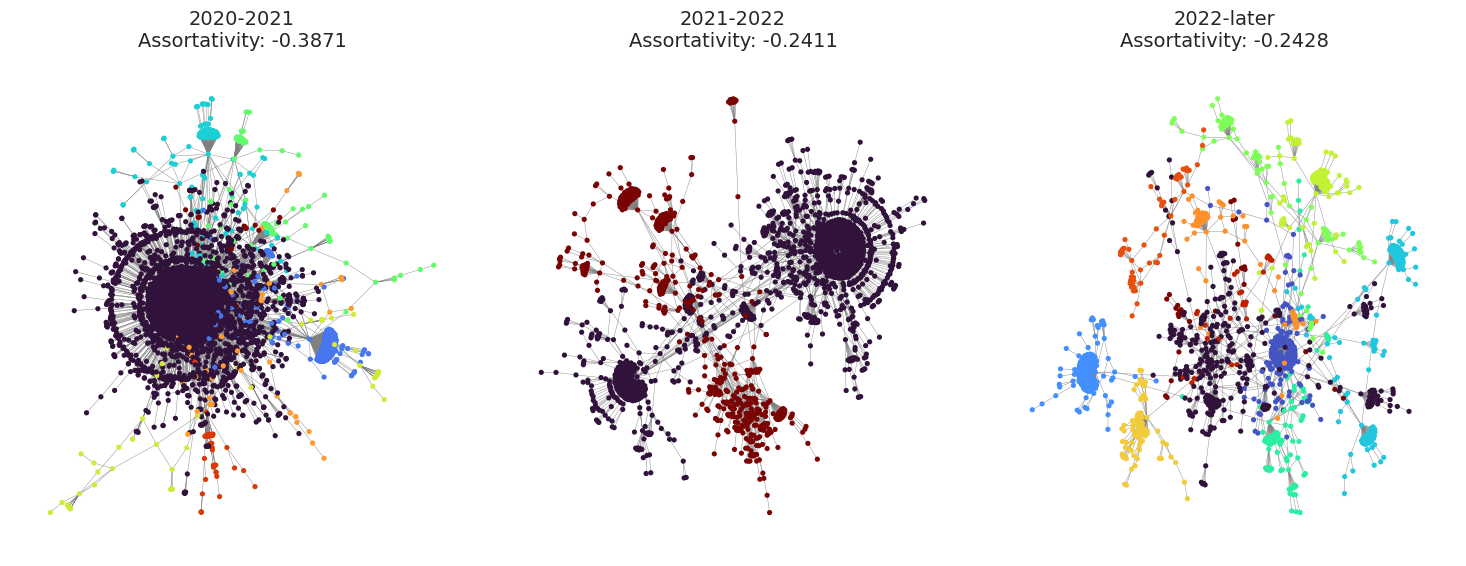

In [37]:
def build_graph(df):
    """Build a graph from the DataFrame, removing self-loops and keeping only the largest connected component."""
    G = nx.Graph()
    for _, r in df.iterrows():
        G.add_edge(r['parent'], r['child'])


    G.remove_edges_from(list(nx.selfloop_edges(G)))
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    return G

# Build graphs for each time period
Gs = [
    build_graph(df_comments_2020_2021), 
    build_graph(df_comments_2021_2022), 
    build_graph(df_comments_later)
]
titles = ['2020-2021', '2021-2022', '2022-later']
poss = [nx.spring_layout(G, iterations=50, seed=1721) for G in Gs]

def community_detection_quite(G, c):
    """Community detection utility function - more quiet version"""
    community_sizes = sorted([len(community) for community in c], reverse=True)
    modularity = nx.community.modularity(G, c)
    coverage, performance = nx.community.partition_quality(G, c)

    # create a DataFrame node-community
    l = []
    i = 0

    for community in c:
        for node in community:
            l.append([node,i])
        i += 1

    # create DataFrame
    df = pd.DataFrame(l, columns=['node', 'community'])
    df = df.set_index('node').reindex(G.nodes()).reset_index()

    return df

def run_infomap(G):
    # Convert partition dictionary to communities list format for community_detection function
    # run infomap
    im = Infomap(silent=True, seed=42)
    id_to_node = im.add_networkx_graph(G)
    im.run()
    partition = {id_to_node[node.node_id]: node.module_id for node in im.iterLeafNodes()}

    c_infomap = []
    partition_values = set(partition.values())
    for community_id in sorted(partition_values):
        community_nodes = [node for node, comm_id in partition.items() if comm_id == community_id]
        c_infomap.append(community_nodes)
    return c_infomap

communities = []
for i in range(0, 3):
    c_infomap = run_infomap(Gs[i])
    df_infomap = community_detection_quite(Gs[i], c_infomap)
    df_infomap.rename(columns={'community': 'community_infomap'}, inplace=True)
    communities.append(df_infomap)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    assortativity = nx.degree_assortativity_coefficient(Gs[i])
    ax = axes[i]
    ax.axis("off")
    nx.draw_networkx(
        Gs[i], pos=poss[i], ax=ax,
        node_color=communities[i]['community_infomap'],
        cmap=plt.cm.turbo,
        edge_color='gray',
        node_size=5,
        with_labels=False,
        width=0.3,
    )
    ax.set_title(titles[i]+f"\nAssortativity: {assortativity:.4f}", fontsize=14)
plt.tight_layout()
plt.show()
  

# 5. Topic Modeling

In [45]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from wordcloud import WordCloud
import praw
import pandas as pd
import json
from datetime import datetime
from nltk.corpus import stopwords
import nltk
from PIL import Image
from bertopic import BERTopic


# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])
df_comments = pd.read_csv('../data/comments_graph_ending_final.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
df_communities = pd.read_csv('../data/communities.csv')
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))
df_communities = pd.read_csv('../data/communities.csv')

In [46]:
mid_2020 = pd.Timestamp("2020-06-30")
mid_2021 = pd.Timestamp("2021-06-30")
mid_2022 = pd.Timestamp("2022-06-30")

df_comments["created_dt"] = pd.to_datetime(df_comments["created_utc"], unit="s")

def assign_period(dt):
    if dt <= mid_2020:
        return "period_1 (until mid_2020)"
    elif dt <= mid_2021:
        return "period_2 (mid_2020 → mid_2021)"
    elif dt <= mid_2022:
        return "period_3 (mid_2021 → mid_2022)"
    else:
        return "period_4 (mid_2022 → end)"

df_comments["custom_period"] = df_comments["created_dt"].apply(assign_period)


In [47]:
period_topic_results = {}

for period, group in df_comments.groupby("custom_period"):
    texts = group["text_comment"].dropna().tolist()

    if len(texts) < 10:
        print(f"Skipping {period}, not enough data ({len(texts)} comments)")
        continue

    topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=False)
    topics, probs = topic_model.fit_transform(texts)

    topic_info = topic_model.get_topic_info()
    topic_info["Representative_Docs"] = [
        topic_model.get_representative_docs(i) for i in topic_info.Topic
    ]

    period_topic_results[period] = {
        "model": topic_model,
        "info": topic_info,
        "texts": texts,
        "topics": topics,
    }


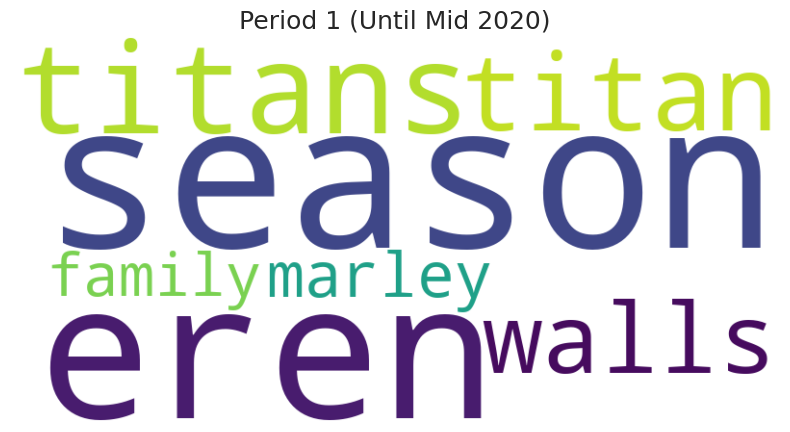

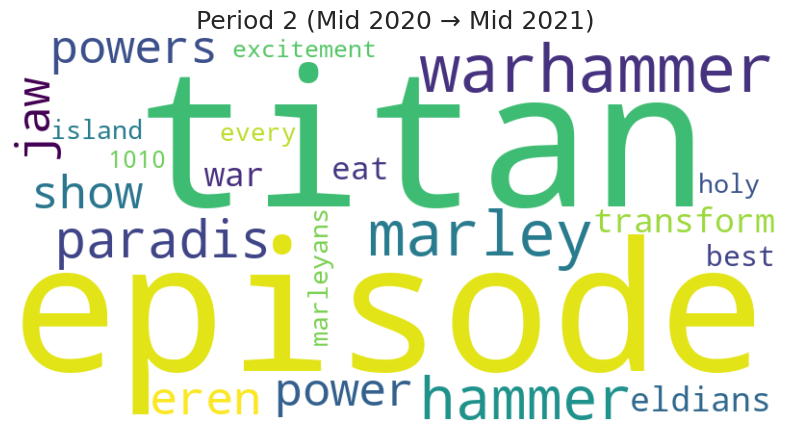

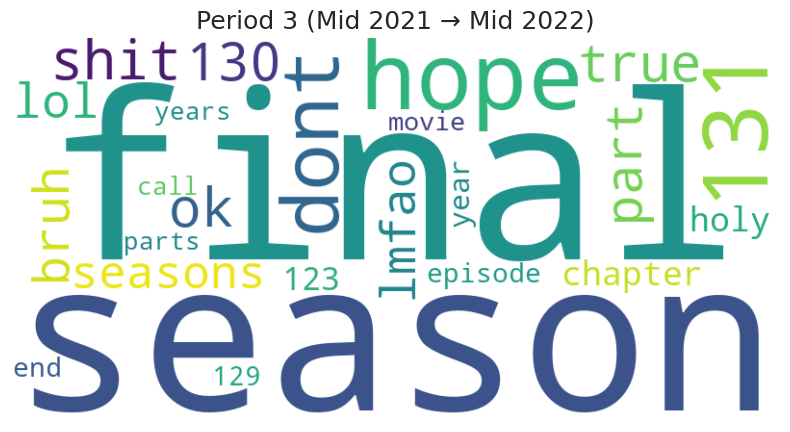

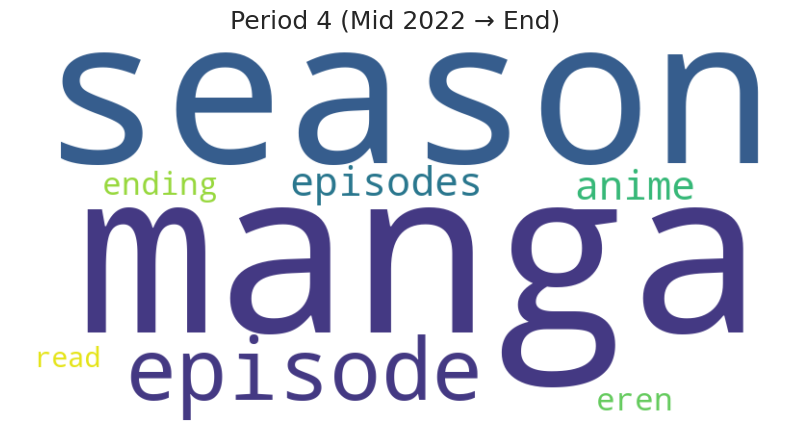

In [50]:
STOPWORDS = set(stopwords.words('english')).union({
    "like", "just", "really", "even", "one", "get", "thing", "things", "also"
})
# NUMBER OF TOPICS TO SHOW
top_n = 3 

for period, data in period_topic_results.items():
    topic_model = data["model"]
    topic_info = topic_model.get_topic_info()

    # Remove outlier topic -1
    topic_info = topic_info[topic_info["Topic"] != -1]
    if topic_info.empty:
        print(f"No valid topics for {period}")
        continue

    top_topics = topic_info.nlargest(top_n, 'Count')[["Topic", "Count"]]

    # Aggregate keywords across top N topics, weighted by topic Count
    word_freq = {}
    for _, row in top_topics.iterrows():
        topic_id = row["Topic"]
        topic_count = row["Count"]
        for word, weight in topic_model.get_topic(topic_id):
            word = word.lower()
            if word not in STOPWORDS:
                # Multiply weight by topic size (Count)
                word_freq[word] = word_freq.get(word, 0) + (weight * topic_count)

    if not word_freq:
        print(f"No keywords left for {period} after stopword removal")
        continue

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(period.replace("_", " ").title())
    plt.show()


# 6. NER

In [41]:
from collections import defaultdict, Counter
import ast
df_comments_sentiment_analysis = pd.read_csv('../data/comments_graph_ending_final_wscores.csv', index_col=0)
df_communities = pd.read_csv('../data/communities.csv')
### LOAD
df_comments = pd.read_csv('../data/comments_graph_with_entities.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
df_comments['entities'] = df_comments['entities'].apply(ast.literal_eval)
df_comments['entities_lowercase'] = df_comments['entities_lowercase'].apply(ast.literal_eval)
df_comments['character_names'] = df_comments['character_names'].apply(ast.literal_eval)

# Merge the sentiment scores with the main dataframe
# we use the score from the BERT-based sentiment analysis model
if 'model_score' not in df_comments.columns:
    df_comments = df_comments.merge(
        df_comments_sentiment_analysis[['comment_id', 'model_score']], 
        on='comment_id', 
        how='left'
    )
# Create a dictionary to store sentiment scores and dates for each entity
entity_sentiment_data = defaultdict(lambda: {'scores': [], 'dates': []})

entities_to_remove = [
    'mappa', 'titan', 'erens', 'paradis', 'isayama', 'marley'
]

for _, row in df_comments.iterrows():
    if pd.notna(row['model_score']) and row['entities_lowercase']:
        sentiment_score = row['model_score']
        comment_date = row['created_utc']
        
        # add sentiment and date for each entity
        for entity, tag in row['entities_lowercase']:
            if tag == 'PERSON' and entity not in entities_to_remove:
                # init the entity in the dictionary if not already present
                if entity not in entity_sentiment_data:
                    entity_sentiment_data[entity] = {'scores': [], 'dates': []}

                entity_sentiment_data[entity]['scores'].append(sentiment_score)
                entity_sentiment_data[entity]['dates'].append(comment_date)

entity_sentiment_data = dict(entity_sentiment_data)


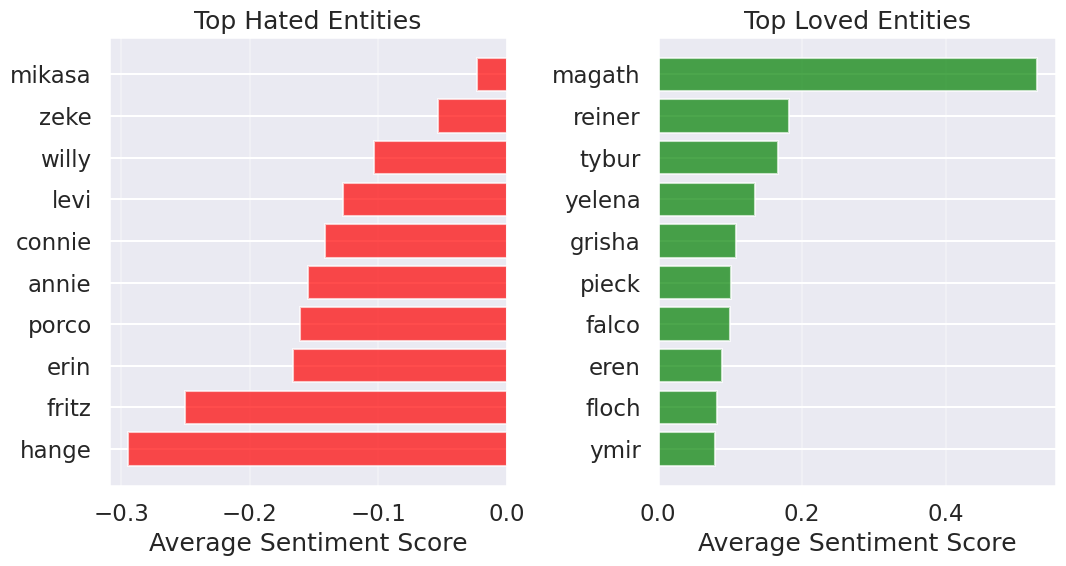

In [42]:
# PARAMETERS
min_comments_threshold = 50 # Set threshold for minimum number of comments
n_entities = 10  # Number of top/bottom entities to show

# Filter entities with enough comments
filtered_entities = {
    entity: data for entity, data in entity_sentiment_data.items() 
    if len(data['scores']) >= min_comments_threshold
}

# Calculate average sentiment for each entity
entity_avg_sentiment = {
    entity: sum(data['scores']) / len(data['scores'])
    for entity, data in filtered_entities.items()
}

sorted_entities = sorted(entity_avg_sentiment.items(), key=lambda x: x[1])
lowest_entities = sorted_entities[:n_entities]
highest_entities = sorted_entities[-n_entities:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

lowest_names, lowest_scores = zip(*lowest_entities)
ax1.barh(range(len(lowest_names)), lowest_scores, color='red', alpha=0.7)
ax1.set_yticks(range(len(lowest_names)))
ax1.set_yticklabels(lowest_names)
ax1.set_xlabel('Average Sentiment Score')
ax1.set_title(f'Top Hated Entities')
ax1.grid(axis='x', alpha=0.3)

highest_names, highest_scores = zip(*highest_entities)
ax2.barh(range(len(highest_names)), highest_scores, color='green', alpha=0.7)
ax2.set_yticks(range(len(highest_names)))
ax2.set_yticklabels(highest_names)
ax2.set_xlabel('Average Sentiment Score')
ax2.set_title(f'Top Loved Entities')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

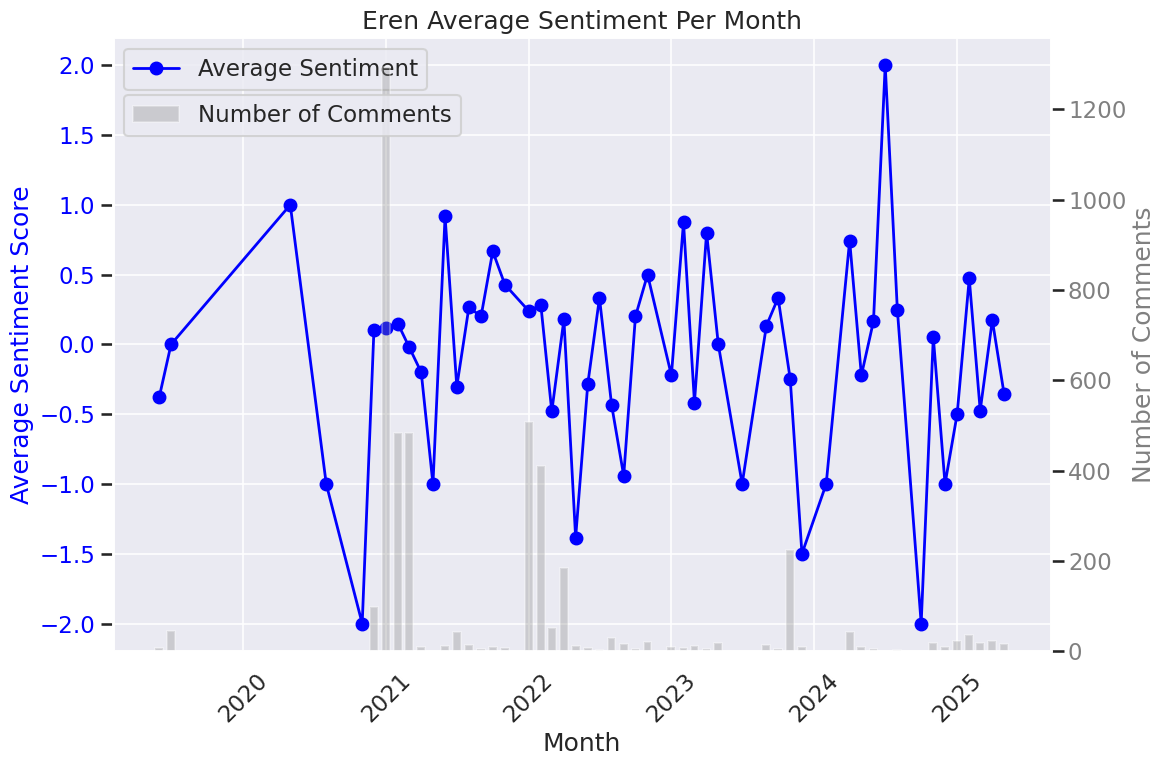

Total comments mentioning Eren: 4301
Average sentiment for Eren: 0.089
Months covered: 52


In [43]:
# Filter data for Eren and create monthly sentiment analysis
eren_data = []
for _, row in df_comments.iterrows():
    if pd.notna(row['model_score']) and row['entities_lowercase']:
        for entity, tag in row['entities_lowercase']:
            if entity.lower() == 'eren':
                # Append the date and sentiment score for Eren
                eren_data.append({
                    'date': row['created_utc'],
                    'sentiment': row['model_score']
                })
                
# Calculate monthly average sentiment
eren_df = pd.DataFrame(eren_data)
eren_df['year_month'] = eren_df['date'].dt.to_period('M')
monthly_sentiment = eren_df.groupby('year_month')['sentiment'].agg(['mean', 'count']).reset_index()
monthly_sentiment['year_month'] = monthly_sentiment['year_month'].dt.to_timestamp()

fig, ax1 = plt.subplots(figsize=(12, 8))

# sentiment line
line = ax1.plot(monthly_sentiment['year_month'], monthly_sentiment['mean'], marker='o', linewidth=2, color='blue', label='Average Sentiment')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.8)
ax1.tick_params(axis='x', rotation=45)

# secondary y-axis for comment counts
ax2 = ax1.twinx()
bars = ax2.bar(monthly_sentiment['year_month'], monthly_sentiment['count'], alpha=0.3, color='gray', width=20, label='Number of Comments')
ax2.set_ylabel('Number of Comments', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False)


plt.title('Eren Average Sentiment Per Month')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.925))

plt.tight_layout()
plt.show()

print(f"Total comments mentioning Eren: {len(eren_df)}")
print(f"Average sentiment for Eren: {eren_df['sentiment'].mean():.3f}")
print(f"Months covered: {len(monthly_sentiment)}")

In [44]:
community_character_sentiment = {}
# unique communities
communities = df_communities['infomap_community'].unique()

for community_id in communities:
    # get nodes per community
    nodes_in_comm = df_communities[df_communities['infomap_community'] == community_id]['node'].tolist()
    
    # filter comments from users in this community
    community_comments = df_comments[df_comments['parent'].isin(nodes_in_comm)]
    
    # get sentiment data for each character in this community
    character_sentiment_data = defaultdict(lambda: {'scores': [], 'count': 0})
    
    for _, row in community_comments.iterrows():
        if pd.notna(row['model_score']) and row['entities_lowercase']:
            sentiment_score = row['model_score']
            
            # add sentiment for each character apperaing in the comment
            for entity, tag in row['entities_lowercase']:
                if tag == 'PERSON' and entity not in entities_to_remove:
                    character_sentiment_data[entity]['scores'].append(sentiment_score)
                    character_sentiment_data[entity]['count'] += 1
    
    # compute avg sentiment for each character
    character_avg_sentiment = {}
    for char, data in character_sentiment_data.items():
        if data['count'] >= 5:  # minimum number of comments threshold
            character_avg_sentiment[char] = {
                'avg_sentiment': sum(data['scores']) / len(data['scores']),
                'count': data['count']
            }
    
    community_character_sentiment[community_id] = {
        'num_users': len(nodes_in_comm),
        'num_comments': len(community_comments),
        'character_sentiment': character_avg_sentiment
    }

In [45]:
from collections import defaultdict, Counter

# Analyze character presence in each community
community_character_analysis = {}

# Get unique communities
communities = df_communities['infomap_community'].unique()

for community_id in communities:
    # Get nodes in this community
    nodes_in_comm = df_communities[df_communities['infomap_community'] == community_id]['node'].tolist()
    
    # Filter comments from users in this community
    community_comments = df_comments[df_comments['parent'].isin(nodes_in_comm)]
    
    # Collect all character mentions from this community
    all_characters_in_comm = []
    for ent_list in community_comments['entities_lowercase']:
        for char_list, tag in ent_list:
            # Append character names to the list if they are of type 'PERSON'
            if tag == 'PERSON':
                all_characters_in_comm.append(char_list)

    # Count character frequencies
    character_counts = Counter(all_characters_in_comm)
    
    # Store results
    community_character_analysis[community_id] = {
        'num_users': len(nodes_in_comm),
        'num_comments': len(community_comments),
        'character_counts': character_counts,
        'top_characters': character_counts.most_common(10)
    }



In [46]:
# Find the most active communities (by number of comments or users)
community_stats = []
for community_id, analysis in community_character_analysis.items():
    community_stats.append({
        'community_id': community_id,
        'num_users': analysis['num_users'],
        'num_comments': analysis['num_comments'],
        'unique_characters': len(analysis['character_counts']),
        'total_character_mentions': sum(analysis['character_counts'].values())
    })

community_stats_df = pd.DataFrame(community_stats)
community_stats_df = community_stats_df.sort_values('num_comments', ascending=False)

# Analyze character diversity and focus patterns
top_6_communities = community_stats_df.head(6)['community_id'].tolist()


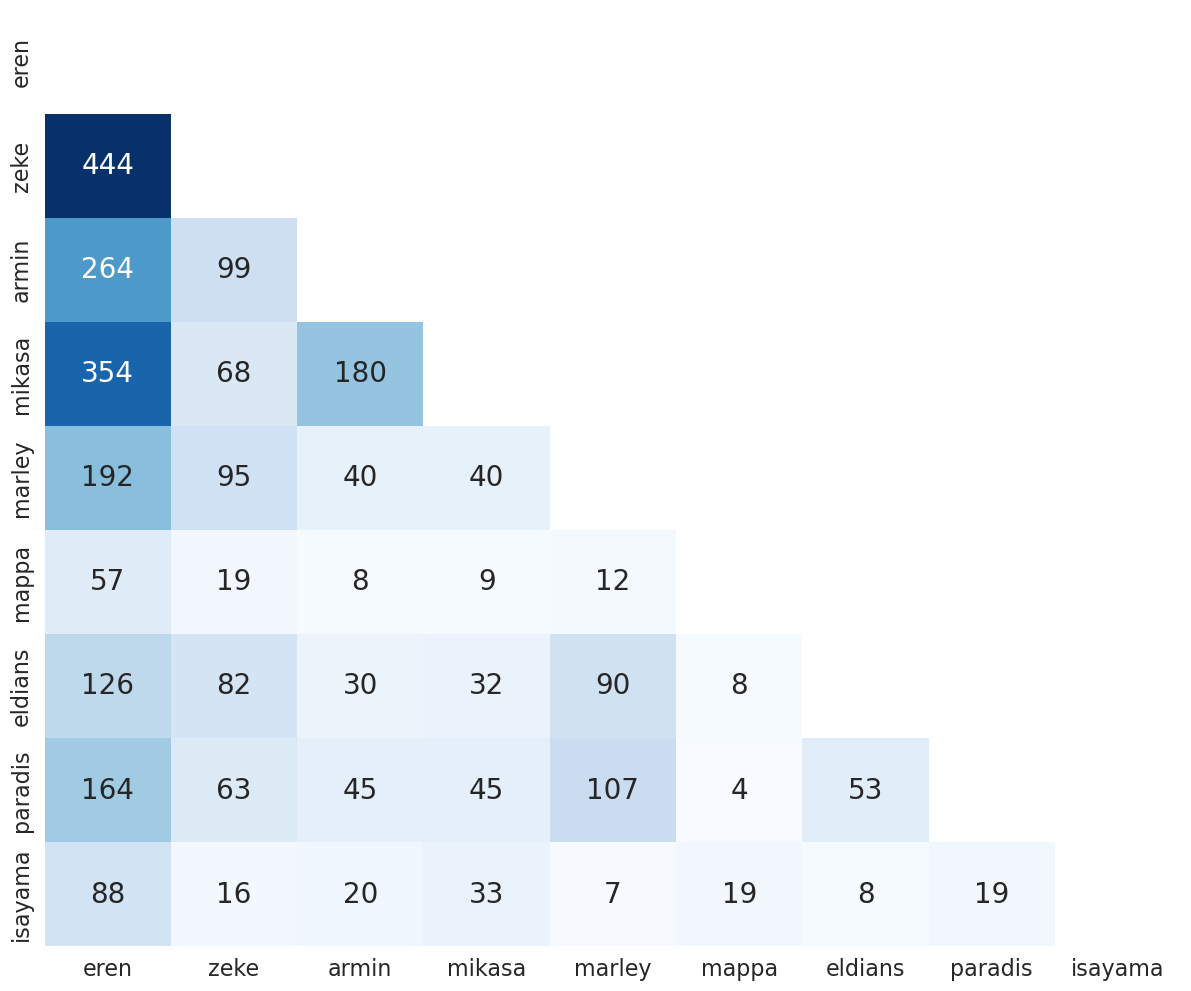

In [70]:
from itertools import combinations
# after a first analysis we see that both eren and Eren are used in the comments
# so we store also a copy of the entities in lowercase
df_comments['entities_lowercase'] = df_comments['entities'].apply(
    lambda ents: [(ent[0].lower(), ent[1]) for ent in ents]
)
flat_entities = [e[0] for sublist in df_comments['entities_lowercase'] for e in sublist]
all_entities = [ent for sublist in df_comments['entities_lowercase'] for ent in sublist]
entity_texts = [e[0] for e in all_entities]
# Build co-occurrence matrix, excluding CARDINAL entities

from itertools import combinations
sns.set_context("paper")

# Define entities to exclude from the heatmap
entities_to_exclude_from_heatmap = ['aot', 'first', 'titan', 'titans', 'reiner', 'gabi', 'ymir', 'grisha', 'levi', 'falco','sasha']

# Build co-occurrence matrix, excluding CARDINAL entities
co_matrix = defaultdict(lambda: defaultdict(int))

for ents in df_comments['entities_lowercase']:
    # Filter out CARDINAL entities
    names = list(set([e[0] for e in ents if e[1] != 'CARDINAL']))
    for a, b in combinations(names, 2):
        co_matrix[a][b] += 1
        co_matrix[b][a] += 1

# Convert to DataFrame (limit to top N, excluding cardinals and specified entities)
entity_texts_no_cardinals = [e[0] for e in all_entities if e[1] != 'CARDINAL']
most_common_entities_no_cardinals = Counter(entity_texts_no_cardinals).most_common(20)  # Get more to account for filtering

# Filter out entities we want to exclude from heatmap
top_entities = [e[0] for e in most_common_entities_no_cardinals 
                if e[0] not in entities_to_exclude_from_heatmap][:20]  # Take top 20 after filtering

matrix = pd.DataFrame([[co_matrix[a][b] for b in top_entities] for a in top_entities],
                      index=top_entities, columns=top_entities)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', mask=mask, cbar=False, annot_kws={'size': 20})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid(False)
plt.show()


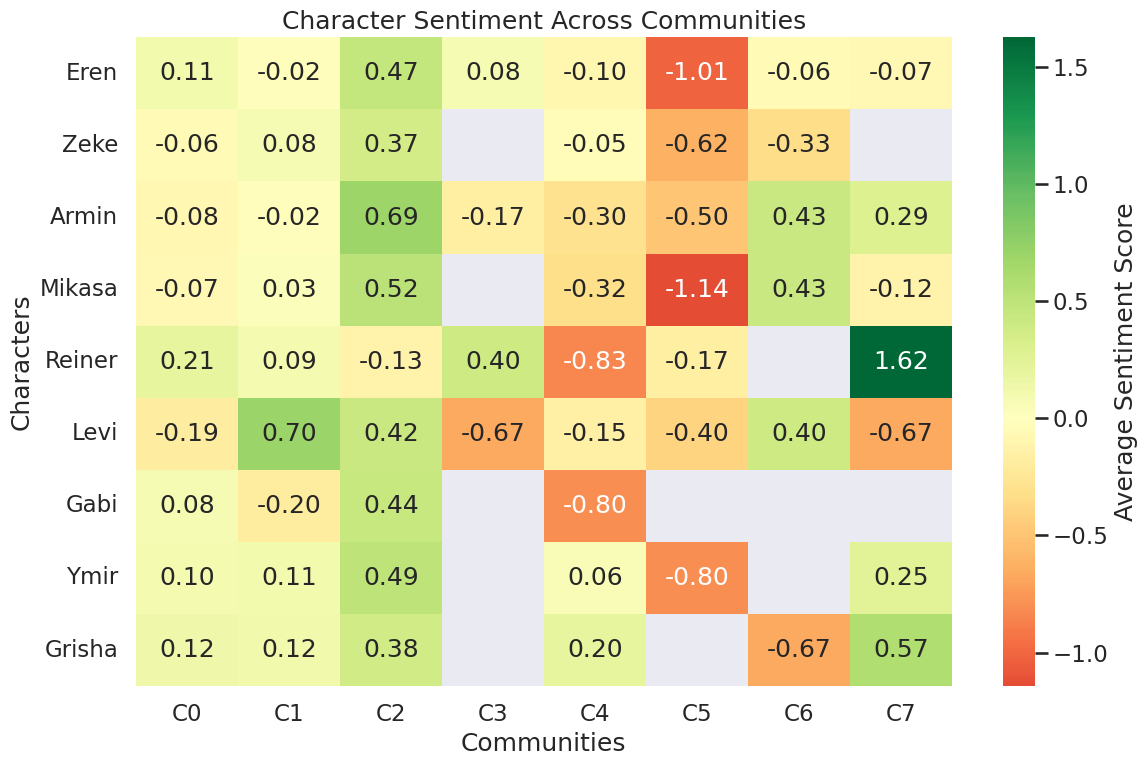

In [78]:
def create_sentiment_heatmap(top_characters=10, top_communities=8):
    """Create a heatmap of character sentiment across communities"""
    
    # most mentioned characters
    all_char_counts = Counter()
    for analysis in community_character_sentiment.values():
        for char, data in analysis['character_sentiment'].items():
            all_char_counts[char] += data['count']
    
    top_chars = [char for char, _ in all_char_counts.most_common(top_characters)]
    top_comms = community_stats_df.head(top_communities)['community_id'].tolist()
    
    # built sentiment matrix
    sentiment_matrix = []
    char_labels = []
    comm_labels = []
    
    for char in top_chars:
        row = []
        for comm_id in top_comms:
            char_data = community_character_sentiment[comm_id]['character_sentiment'].get(char)
            if char_data and char_data['count'] >= 3:
                row.append(char_data['avg_sentiment'])
            else:
                row.append(np.nan)
        
        # only include characters with data in at least half the communities
        if sum(1 for x in row if not pd.isna(x)) >= len(top_comms) // 2:
            sentiment_matrix.append(row)
            char_labels.append(char.title())
    
    comm_labels = [f"C{comm_id}" for comm_id in top_comms]
    
    plt.figure(figsize=(12, 8))
    sentiment_df = pd.DataFrame(sentiment_matrix, index=char_labels, columns=comm_labels)
    
    sns.heatmap(sentiment_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Average Sentiment Score'})
    plt.title('Character Sentiment Across Communities')
    plt.xlabel('Communities')
    plt.ylabel('Characters')
    plt.tight_layout()
    plt.grid(False)
    plt.show()
    
    return sentiment_df

sentiment_heatmap = create_sentiment_heatmap(top_characters=10, top_communities=8)